# Analyze and plot neutralization curves

Import Python packages.
Use the [neutcurve](https://jbloomlab.github.io/neutcurve/) package for fitting the neutralization curves:

In [1]:
import glob
import math
import os

from IPython.display import display, SVG

import matplotlib.pyplot as plt

import neutcurve
from neutcurve.colorschemes import CBPALETTE, CBMARKERS
print(f"Using neutcurve version {neutcurve.__version__}")

import pandas as pd

from plotnine import *

import svgutils

Using neutcurve version 0.5.2


Read in CSVs with the the fraction infectivity for all assay dates into a single merged data frame.
Note that for the 2020-11-19 data, the virus and the serum columns are inverted in the original CSV, so fix this:

In [2]:
fracinfect = pd.DataFrame()

for date_fracinfect_csv in glob.glob('data/*.csv'):
    date = os.path.basename(date_fracinfect_csv).split('_')[0]  # extract date from file name
    print(f"Reading neut data for {date} from {date_fracinfect_csv}")
    date_fracinfect = pd.read_csv(date_fracinfect_csv, index_col=0).assign(date=date)
    if date == '20201119':
        # virus and serum columns were swapped in original CSV for this date; fix this
        date_fracinfect = date_fracinfect.rename(columns={'virus': 'serum', 'serum': 'virus'})
    fracinfect = fracinfect.append(date_fracinfect)
    
# make column called 'serum_date' since to plot sera measurements on different dates differently
fracinfect = (fracinfect
              .assign(serum_date=lambda x: x['serum'] + '_' + x['date'].astype(str))
              )

# summarize what we read
print(f"\nRead neutralization data for the following sera / virus on the indicated dates:")
display(fracinfect
        [['serum', 'virus', 'date']]
        .groupby(['serum', 'virus'])
        .aggregate({'date': 'unique'})
        )
print(f"\nHere are the first few lines of the fraction-infectivity data frame:")
display(fracinfect.head())

Reading neut data for 20201119 from data/20201119_neuts_fractinect2.csv
Reading neut data for 20201125 from data/20201125_REGN_fracinfect.csv
Reading neut data for 20201122 from data/20201122_CB6_fracinfect.csv
Reading neut data for 20201210 from data/20201210_REGN_repeat_fractinfect.csv

Read neutralization data for the following sera / virus on the indicated dates:


date
serum               virus                                
CB6                 A475V                      [20201122]
                    E406W                      [20201210]
                    K417N                      [20201122]
                    N460T                      [20201122]
                    WT     [20201119, 20201122, 20201210]
REGN10933           E406W            [20201125, 20201210]
                    F486K            [20201125, 20201210]
                    K444Q            [20201125, 20201210]
                    N439K            [20201125, 20201210]
                    WT     [20201119, 20201125, 20201210]
REGN10933+REGN10987 E406W            [20201125, 20201210]
                    F486K            [20201125, 20201210]
                    K444Q            [20201125, 20201210]
                    N439K            [20201125, 20201210]
                    WT     [20201119, 20201125, 20201210]
REGN10987           E406W            [20201125, 20201210]
                    F486K            [20201125, 20201210]
                    K444Q            [20201125, 20201210]
                    N439K            [20201125, 20201210]
                    WT     [20201119, 20201125, 20201210]


Here are the first few lines of the fraction-infectivity data frame:


,virus,serum,replicate,concentration,fraction infectivity,date,serum_date
0,WT,REGN10933+REGN10987,1,3.00000,-0.002835,20201119,REGN10933+REGN10987_20201119
1,WT,REGN10933+REGN10987,1,1.00000,-0.002357,20201119,REGN10933+REGN10987_20201119
2,WT,REGN10933+REGN10987,1,0.33330,-0.002746,20201119,REGN10933+REGN10987_20201119
3,WT,REGN10933+REGN10987,1,0.11110,0.050270,20201119,REGN10933+REGN10987_20201119
4,WT,REGN10933+REGN10987,1,0.03704,0.016170,20201119,REGN10933+REGN10987_20201119


Now fit all the neutralization curves, fitting sera by date:

In [3]:
fits = neutcurve.CurveFits(fracinfect,
                           serum_col='serum_date')

First just plot all the neutralization curves organizing by the serum / date:

/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/neutcurve/hillcurve.py:689: RuntimeWarning: invalid value encountered in power


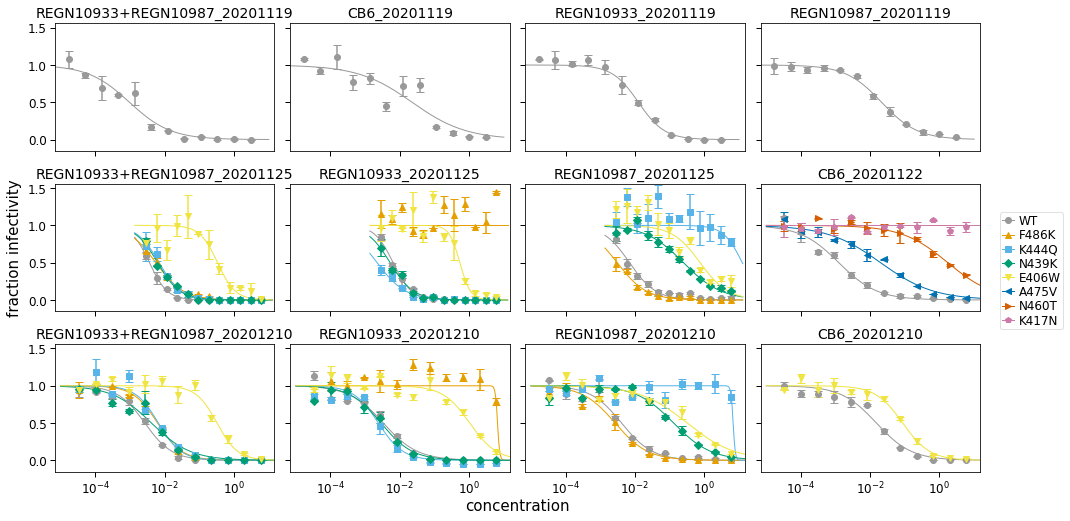

In [4]:
_ = fits.plotSera(widthscale=1.1)

Now lets make the curves we want to actually show for the paper supplementary figure:


Here is neutralization panel A. Saving to neutcurves_A.svg:


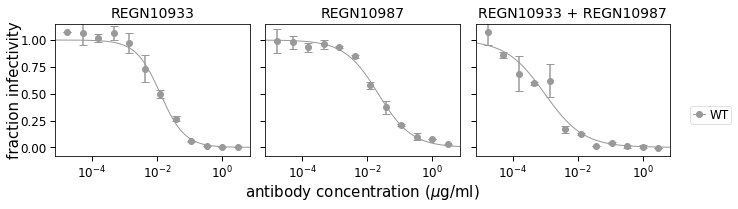


Here is neutralization panel B. Saving to neutcurves_B.svg:


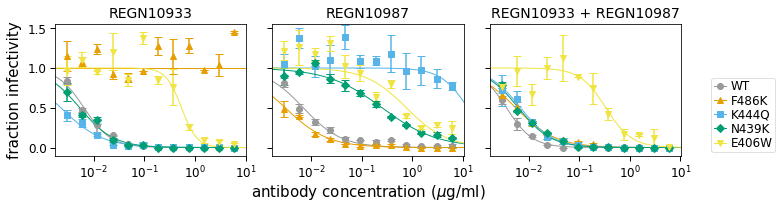


Here is neutralization panel C. Saving to neutcurves_C.svg:


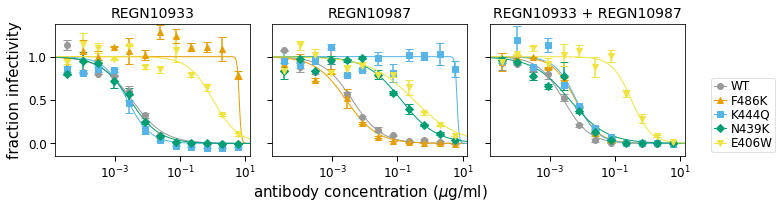


Here is neutralization panel D. Saving to neutcurves_D.svg:


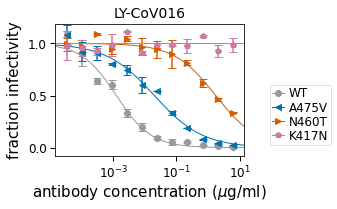


Here is neutralization panel E. Saving to neutcurves_E.svg:


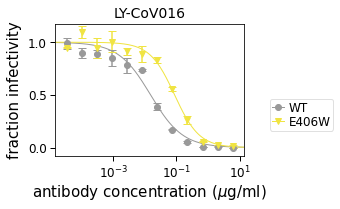

In [5]:
# Common color scheme for viruses
virus_to_color_marker = {v: (c, m) for v, c, m in
                         zip(fits.allviruses, CBPALETTE, CBMARKERS)}

svg_files = {}
for panel, sera_dates, widthscale in [
        ('A',
         ['REGN10933_20201119', 'REGN10987_20201119', 'REGN10933+REGN10987_20201119'],
         1
         ),
        ('B',
         ['REGN10933_20201125', 'REGN10987_20201125', 'REGN10933+REGN10987_20201125'],
         1.04),
        ('C',
         ['REGN10933_20201210', 'REGN10987_20201210', 'REGN10933+REGN10987_20201210'],
         1.04),
        ('D',
         ['CB6_20201122'],
         1.04),
        ('E',
         ['CB6_20201210'],
         1.04),    
        ]:
    sera_names = [s.split('_')[0].replace('+', ' + ').replace('CB6', 'LY-CoV016')
                  for s in sera_dates]
    fig_panel, _ = fits.plotSera(sera=sera_dates,
                                 titles=sera_names,
                                 widthscale=widthscale,
                                 heightscale=1.05,
                                 xlabel='antibody concentration ($\mu$g/ml)',
                                 virus_to_color_marker=virus_to_color_marker)
    svg_file = f"neutcurves_{panel}.svg"
    svg_files[panel] = svg_file
    print(f"\nHere is neutralization panel {panel}. Saving to {svg_file}:")
    display(fig_panel)
    fig_panel.savefig(svg_file)
    plt.close(fig_panel)

Read and plot viral titers:


Here are titers. Saving to titers.svg:


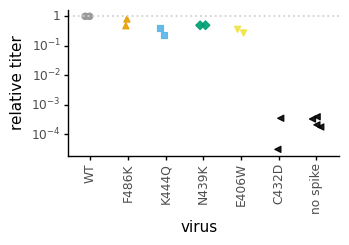

In [6]:
titers = (pd.read_csv('titer_data/20201210_REGN_titer2.csv')
          .rename(columns={'Normalized Titer': 'relative titer'})
          .assign(virus=lambda x: x['Construct']
                                  .map(lambda s: 'no spike' if
                                                  s == 'Negative' else s)
                  )
          )
titer_viruses = [v for v in virus_to_color_marker if v in titers['virus'].unique()]
titer_colors = [virus_to_color_marker[v][0] for v in titer_viruses]
titer_shapes = [virus_to_color_marker[v][1] for v in titer_viruses]
extras = ['C432D', 'no spike']
titer_viruses += extras
titer_colors += ['black' for _ in extras]
titer_shapes += ['<' for _ in extras]

titers = (titers
          .query('virus in @titer_viruses')
          .assign(virus=lambda x: pd.Categorical(x['virus'], titer_viruses, ordered=True))
          )

p = (ggplot(titers) +
     aes(x='virus', y='relative titer', color='virus', shape='virus') + 
     geom_jitter(width=0.15, height=0, size=2, alpha=0.9, random_state=1) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(3.5, 1.9),
           legend_position='none') +
     geom_hline(yintercept=1, linetype='dotted', color='lightgray',
               size=0.75) +
     scale_y_log10(labels=lambda ys: [f"${y:.1g}$" if abs(math.log10(y)) < 1 else
                                      f"$10^{{{int(math.log10(y))}}}$" for y in ys]
                   ) +
     scale_color_manual(values=titer_colors) +
     scale_shape_manual(values=titer_shapes)
     )

svg_file = 'titers.svg'
svg_files['F'] = svg_file
print(f"\nHere are titers. Saving to {svg_file}:")
fig = p.draw()
fig.savefig(svg_file, bbox_inches='tight', pad_inches=0.3)
display(fig)
plt.close(fig)

Use [svgutils](https://svgutils.readthedocs.io/en/latest/tutorials/composing_multipanel_figures.html) to compose the panels into a single SVG:

In [7]:
neut_svg = 'neutcurves.svg'

panels = [svgutils.compose.Panel(svgutils.compose.SVG(svg).scale(1 + 0.35 * (int(panel == 'F'))),
                                 svgutils.compose.Text(panel, 25, 20, size=25, weight='bold', font='Arial')
                                 ).move(425 * int(panel == 'E'),
                                        230 * (i - int(panel in {'E', 'F'})))
          for i, (panel, svg) in enumerate(svg_files.items())]

svgutils.compose.Figure('22cm', '31cm', *panels
                        ).save(neut_svg)

print(f"Creating merged SVG file {neut_svg}:\n")
display(SVG(neut_svg))

Creating merged SVG file neutcurves.svg:



Get changes:
 - in IC50 for all mutations
 - subset to the two assay dates of interest (2020-11-22 and 2020-11-25)
 - get antibody names without dates
 - rename CB6 to LY-CoV016
 - get antibodies / viruses in desired order
 - determine wildtype IC50 and fold change, and lower and upper limits on IC50s where relevant
 - use manual annotations to note which mutations are **expected** to escape

In [8]:
# Get IC50s of interest with properly named antibodies
fitparams = (
    fits.fitParams()
    .assign(date=lambda x: x['serum'].str.split('_').str[1],
            antibody=lambda x: x['serum'].str.split('_').str[0]
                               .str.replace('CB6', 'LY-CoV016')
                               .str.replace('+', ' + '),
            )
    .query('date in ["20201122", "20201125", "20201210"]')
    )

# order antibodies and viruses how we want to plot
antibody_order = ['REGN10933', 'REGN10987', 'REGN10933 + REGN10987', 'LY-CoV016']
assert set(fitparams['antibody']).issubset(set(antibody_order))
virus_order = ['WT', 'E406W', 'K417N', 'N439K', 'K444Q', 'N460T', 'A475V', 'F486K']
assert set(fitparams['virus']).issubset(set(virus_order))
fitparams = (fitparams
             .assign(antibody=lambda x: pd.Categorical(x['antibody'], antibody_order, ordered=True))
             .assign(virus=lambda x: pd.Categorical(x['virus'], virus_order, ordered=True))
             .sort_values(['antibody', 'virus'])
             .reset_index(drop=True)
             )

# add in wildtype IC50s, and upper / lower bound if any for this antibody
fitparams = (
    fitparams
    # add wildtype IC50
    .merge(fitparams.query('virus == "WT"')
                    .rename(columns={'ic50': 'WT_ic50'})
                    [['antibody', 'WT_ic50', 'date']],
           how='left',
           on=['antibody', 'date'],
           validate='many_to_one',
           )
    .assign(fold_change=lambda x: x['ic50'] / x['WT_ic50'],
            at_bound=lambda x: (x['ic50_bound'] == 'interpolated').map({True: 'no', False: 'yes'})
            )
    )

# annotate expected escape mutations
expected_escape = {'REGN10933': ['E406W', 'F486K'],
                   'REGN10987': ['E406W', 'N439K', 'K444Q'],
                   'REGN10933 + REGN10987': ['E406W'],
                   'LY-CoV016': ['K417N', 'N460T', 'A475V']}
fitparams = (fitparams
             .assign(escape_expected=lambda x: x.apply(lambda r: r['virus'] in expected_escape[r['antibody']],
                                                       axis=1).map({True: 'yes', False: 'no'}),
                     )
             )

# get just columns of interest
fitparams = fitparams[['antibody', 'virus', 'date', 'fold_change', 'escape_expected', 'at_bound',
                       'ic50', 'ic50_bound', 'ic50_str', 'WT_ic50']]

ic50_csv = 'ic50s.csv'
print(f"Here are the fit parameters; writing to {ic50_csv}")
fitparams.to_csv(ic50_csv, index=False)
display(fitparams)

Here are the fit parameters; writing to ic50s.csv


,antibody,virus,date,fold_change,escape_expected,at_bound,ic50,ic50_bound,ic50_str,WT_ic50
0,REGN10933,WT,20201125,1.000000,no,no,0.006403,interpolated,0.0064,0.006403
1,REGN10933,WT,20201210,1.000000,no,no,0.003341,interpolated,0.00334,0.003341
2,REGN10933,E406W,20201125,84.380461,yes,no,0.540302,interpolated,0.54,0.006403
3,REGN10933,E406W,20201210,311.103447,yes,no,1.039265,interpolated,1.04,0.003341
4,REGN10933,N439K,20201125,0.821428,no,no,0.005260,interpolated,0.00526,0.006403
5,REGN10933,N439K,20201210,0.863746,no,no,0.002885,interpolated,0.00289,0.003341
6,REGN10933,K444Q,20201125,0.457586,no,yes,0.002930,upper,<0.00293,0.006403
7,REGN10933,K444Q,20201210,0.723081,no,no,0.002416,interpolated,0.00242,0.003341
8,REGN10933,F486K,20201125,937.037093,yes,yes,6.000000,lower,>6,0.006403
9,REGN10933,F486K,20201210,1796.097618,yes,yes,6.000000,lower,>6,0.003341


Now plot the escape:

Saving to escape_plot.svg


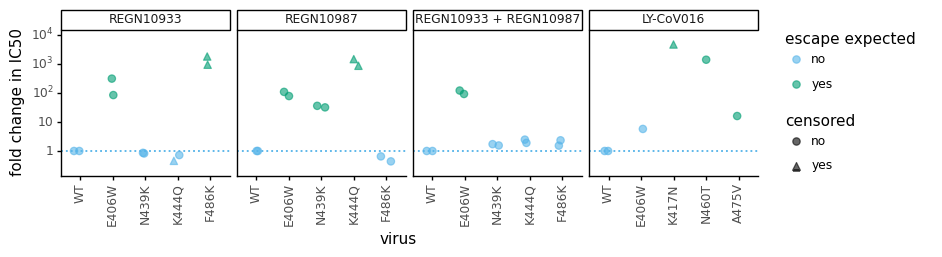

In [9]:
p_escape = (
    ggplot(fitparams.rename(columns={'escape_expected': 'escape expected',
                                     'at_bound': 'censored'})) +
    aes('virus', 'fold_change', color='escape expected', shape='censored') +
    geom_jitter(size=2.5, alpha=0.6, random_state=2, height=0, width=0.2) +
    geom_hline(yintercept=1, linetype='dotted', color=CBPALETTE[2],
               size=0.75) +
    scale_y_log10(name='fold change in IC50', expand=(0, 0.5),
                  labels=lambda ys: [f"${int(y)}$" if y < 100 else f"$10^{int(math.log10(y))}$" for y in ys]) +
    facet_wrap('~ antibody', nrow=1, scales='free_x') +
    theme_classic() +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(9, 1.9),
          ) +
    scale_color_manual(values=[CBPALETTE[2], CBPALETTE[3]])
    )

_ = p_escape.draw()

escape_plot = 'escape_plot.svg'
print(f"Saving to {escape_plot}")
p_escape.save(escape_plot, verbose=False)